In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import corner
import astropy.cosmology as cosmo
from astropy.cosmology import Planck18
import astropy.units as u
import copy
from sklearn.mixture import GaussianMixture
from scipy.stats import truncnorm
import scipy.stats as ss

from scipy.interpolate import RectBivariateSpline, interp1d

seed = 1023123283

# Data Generation

In [2]:
with h5py.File("gmm.h5",'r') as hf:
    nc = np.array(hf['nc'])
    mean = np.array(hf['mean'])
    cov = np.array(hf['cov'])
    weight = np.array(hf['weight'])
    Mcinj_100000 = np.array(hf['Mcinj'])
    logqinj_100000 = np.array(hf['logqinj'])
    zinj_100000 = np.array(hf['zinj'])
hf.close()

In [3]:
gm = GaussianMixture(int(nc))
gm.weights_ = weight
gm.means_ = mean
gm.covariances_ = cov

In [4]:
uncert = {
    'threshold_snr': 8,
    'Theta': 0.05,
    'mcz': 0.03,
    'logq': 0.64
}
rho_th = 8.0

In [5]:
with h5py.File('optimal_snr_CosmicExplorerWidebandP1600143.h5', 'r') as inp:
    ms = np.array(inp['ms'])
    osnrs = np.array(inp['SNR'])

osnr_interp = RectBivariateSpline(ms, ms, osnrs)

def optimal_snr(Mcz, logq, dl):
    m1z = Mcz*(np.exp(logq)**(-3/5))*(1+np.exp(logq))**(1/5)
    m2z = Mcz*(np.exp(logq)**(2/5))*(1+np.exp(logq))**(1/5)
    return osnr_interp.ev(m1z, m2z)/dl

def rho(optimal_snr, Theta):
    return optimal_snr*Theta

In [26]:
def mcz_add_err(Mcz, rho_obs, uncert, Nsamp):
    Nobs = Mcz.shape[0]
    sigma_Mcz = uncert['threshold_snr']/rho_obs*uncert['mcz']
    Mczo = Mcz+ sigma_Mcz*np.random.randn(Nobs)
    Mczs = np.random.normal(Mczo[:,None], sigma_Mcz[:,None], size=(Nobs,Nsamp))
    return Mczs

def logq_add_err(logq, rho_obs, uncert, Nsamp):
    Nobs = logq.shape[0]
    sigma_logq = uncert['threshold_snr']/rho_obs*uncert['logq']
    bo = -logq/sigma_logq
    logqo = truncnorm.rvs(a=-np.inf*np.ones(Nobs), b=bo, loc=logq, scale=sigma_logq, size=Nobs)

    bs = []
    for i in range(Nobs):
        bs.append(np.repeat(-logqo[i]/sigma_logq[i], Nsamp))
    bs = np.array(bs)
    logqs = truncnorm.rvs(a=-np.inf*np.ones((Nobs,Nsamp)), b=bs, loc=logqo[:,None],
                          scale=sigma_logq[:,None], size=(Nobs,Nsamp))
    
    logqs_reweighted = []
    for i in range(Nobs):
        w = ss.norm.cdf(-logqo[i]/sigma_logq[i])/ss.norm.cdf(-logqs[i]/sigma_logq[i])
        logqs_reweighted.append(np.random.choice(logqs[i], size=Nsamp, p=w/np.sum(w), replace=True))
    logqs_reweighted = np.array(logqs_reweighted)

    return logqs_reweighted

def Theta_add_err(Theta, rho_obs, uncert, Nsamp):
    Nobs = Theta.shape[0]
    sigma_Theta = uncert['threshold_snr']/rho_obs*uncert['Theta']
    ao_T = -Theta/sigma_Theta
    bo_T = (1-Theta)/sigma_Theta
    Thetao = truncnorm.rvs(a=ao_T, b=bo_T, loc=Theta, scale=sigma_Theta, size=Nobs)

    as_T = []
    for i in range(Nobs):
        as_T.append(np.repeat(-Thetao[i]/sigma_Theta[i], Nsamp))
    as_T = np.array(as_T)
    
    bs_T = []
    for i in range(Nobs):
        bs_T.append(np.repeat((1-Thetao[i])/sigma_Theta[i], Nsamp))
    bs_T = np.array(bs_T)
    
    Thetas = truncnorm.rvs(a=as_T, b=bs_T, loc=Thetao[:,None],
                          scale=sigma_Theta[:,None], size=(Nobs,Nsamp))
    
    Thetas_reweighted = []
    for i in range(Nobs):
        w = (ss.norm.cdf((1-Thetao[i])/sigma_Theta[i]) - ss.norm.cdf(-Thetao[i]/sigma_Theta[i]))/(ss.norm.cdf((1-Thetas[i])/sigma_Theta[i]) - ss.norm.cdf(-Thetas[i]/sigma_Theta[i]))
        Thetas_reweighted.append(np.random.choice(Thetas[i], size=Nsamp, p=w/np.sum(w), replace=True))
    Thetas_reweighted = np.array(Thetas_reweighted)
    
    return Thetas_reweighted

def rhos_samples(rho_obs, Nsamp):
    Nobs = rho_obs.shape[0]
    rhos = np.random.normal(rho_obs[:,None], np.ones(Nobs)[:,None], size=(Nobs,Nsamp))
    return rhos

def dl_add_err(dl, Mczs, logqs, Thetas, rhos, uncert, Nsamp):
    Nobs = dl.shape[0]
    dfid = 1.
    ds = dfid*optimal_snr(Mczs, logqs, dfid)*Thetas/rhos
    
    return ds

def reweighted_samples(Mczs, logqs, Thetas, ds):
    Nobs = Mczs.shape[0]
    Nsamp = Mczs.shape[1]
    
    Mczs_reweighted = []
    logqs_reweighted = []
    Thetas_reweighted = []
    ds_reweighted = []
    
    for i in range(Nobs):
        dfid = 1.
        w = ds[i]**2/(Thetas[i]*optimal_snr(Mczs[i], logqs[i], dfid)*dfid)
        Mczs_reweighted.append(np.random.choice(Mczs[i], size=Nsamp, p=w/np.sum(w), replace=True))
        logqs_reweighted.append(np.random.choice(logqs[i], size=Nsamp, p=w/np.sum(w), replace=True))
        Thetas_reweighted.append(np.random.choice(Thetas[i], size=Nsamp, p=w/np.sum(w), replace=True))
        ds_reweighted.append(np.random.choice(ds[i], size=Nsamp, p=w/np.sum(w), replace=True))
    Mczs_reweighted = np.array(Mczs_reweighted)
    logqs_reweighted = np.array(logqs_reweighted)
    Thetas_reweighted = np.array(Thetas_reweighted)
    ds_reweighted = np.array(ds_reweighted)
    
    return Mczs_reweighted, logqs_reweighted, Thetas_reweighted, ds_reweighted

In [27]:
with h5py.File('Nobs.h5', 'r') as inp:
    Nobs_arr = np.array(inp['Nobs_arr'])
inp.close()
Nobs_arr

array([  108,  3595,  6897, 10552, 13741, 17033, 20525, 23946, 27321,
       30483])

In [28]:
with h5py.File("mock_data.h5", "w") as file:
    for i in range(len(Nobs_arr)):
        Nobs = Nobs_arr[i]
        
        gm_samp, _ = gm.sample(Nobs)
        Mc, logq, z = gm_samp.T
        
        mask = z<0
        z[mask] = -z[mask]
        mask1 = logq>0
        logq[mask1] = -logq[mask1]
        
        Mcz = Mc*(1+z)
        dl = Planck18.luminosity_distance(z).to(u.Gpc).value
        
        Theta = np.random.beta(2, 4, Nobs)
        
        rho_obs = rho(optimal_snr(Mcz, logq, dl), Theta) + np.random.randn(Nobs)
        mask2 = rho_obs>rho_th
        rho_obs = rho_obs[mask2]
        Mcz = Mcz[mask2]
        logq = logq[mask2]
        dl = dl[mask2]
        Theta = Theta[mask2]
        Ndet = rho_obs.shape[0]
        print("Ndet=", Ndet, "among Nobs=", Nobs)
        
        Nsamp = 1000
        
        Mczs = mcz_add_err(Mcz, rho_obs, uncert, Nsamp)
        logqs = logq_add_err(logq, rho_obs, uncert, Nsamp)
        Thetas = Theta_add_err(Theta, rho_obs, uncert, Nsamp)
        
        rhos = rhos_samples(rho_obs, Nsamp)
        ds = dl_add_err(dl, Mczs, logqs, Thetas, rhos, uncert, Nsamp)
        
        Mczs_reweighted, logqs_reweighted, Thetas_reweighted, ds_reweighted = reweighted_samples(Mczs, logqs, Thetas, ds)
        
        file.create_dataset('Ndet'+str(i), data=Ndet)
        file.create_dataset('Mcz'+str(i), data=Mcz)
        file.create_dataset('logq'+str(i), data=logq)
        file.create_dataset('Theta'+str(i), data=Theta)
        file.create_dataset('dl'+str(i), data=dl)
        file.create_dataset('Mczs'+str(i), data=Mczs_reweighted)
        file.create_dataset('logqs'+str(i), data=logqs_reweighted)
        file.create_dataset('Thetas'+str(i), data=Thetas_reweighted)
        file.create_dataset('ds'+str(i), data=ds_reweighted)
file.close()

Ndet= 15 among Nobs= 108
Ndet= 445 among Nobs= 3595
Ndet= 884 among Nobs= 6897
Ndet= 1329 among Nobs= 10552
Ndet= 1645 among Nobs= 13741
Ndet= 2115 among Nobs= 17033
Ndet= 2542 among Nobs= 20525
Ndet= 3034 among Nobs= 23946
Ndet= 3476 among Nobs= 27321
Ndet= 3831 among Nobs= 30483


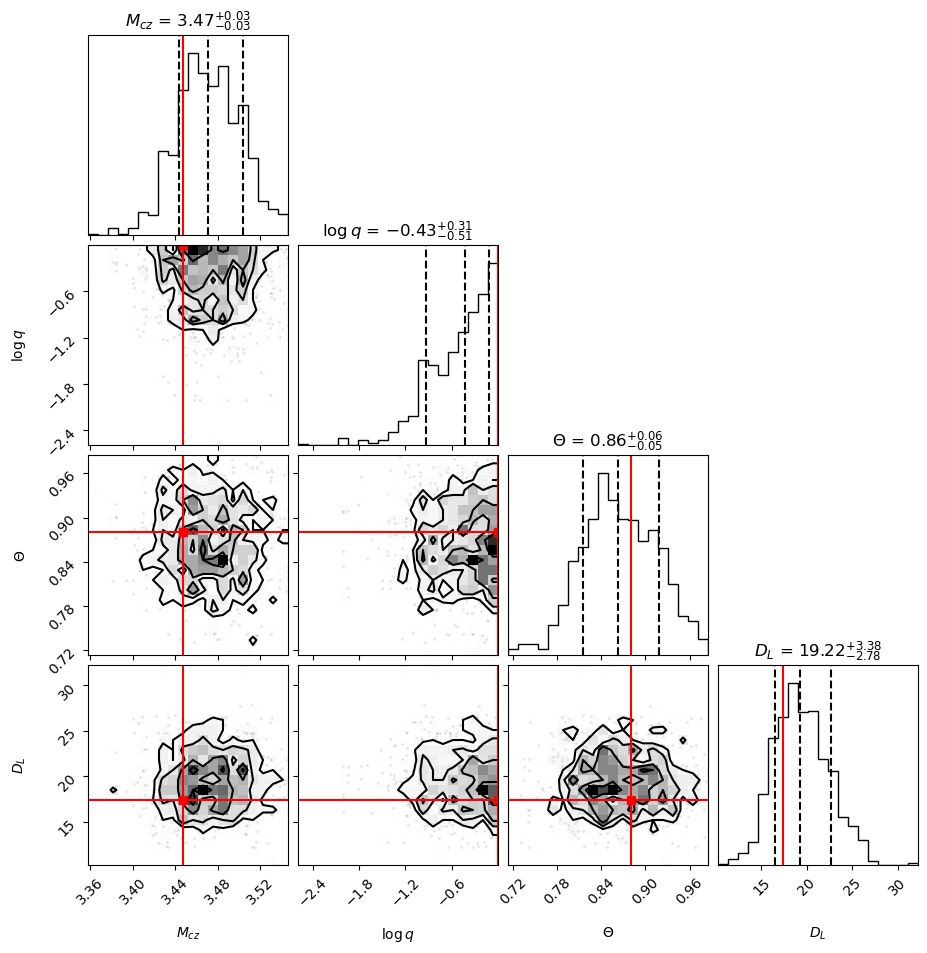

In [29]:
i=9

with h5py.File("mock_data.h5",'r') as hf:
    Mcz = np.array(hf['Mcz'+str(i)])
    logq = np.array(hf['logq'+str(i)])
    Theta = np.array(hf['Theta'+str(i)])
    dl = np.array(hf['dl'+str(i)])
    Mczs = np.array(hf['Mczs'+str(i)])
    logqs = np.array(hf['logqs'+str(i)])
    Thetas = np.array(hf['Thetas'+str(i)])
    ds = np.array(hf['ds'+str(i)])
hf.close()

evt = np.random.randint(0, Mczs.shape[0])
data = np.array([Mczs[evt],logqs[evt],Thetas[evt],ds[evt]]).T
true = np.array([Mcz[evt],logq[evt],Theta[evt],dl[evt]])
figure = corner.corner(
    data,
    labels=[
        r"$M_{cz}$",
        r"$\log q$",
        r"$\Theta$",
        r"$D_L$",
    ],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
)

# Extract the axes
axes = np.array(figure.axes).reshape((len(true), len(true)))

# Loop over the diagonal
for i in range(len(true)):
    ax = axes[i, i]
    ax.axvline(true[i], color="r")



# Loop over the histograms
for yi in range(len(true)):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(true[xi], color="r")
        ax.axhline(true[yi], color="r")
        ax.plot(true[xi], true[yi], "sr")

Text(0, 0.5, 'dl-ds')

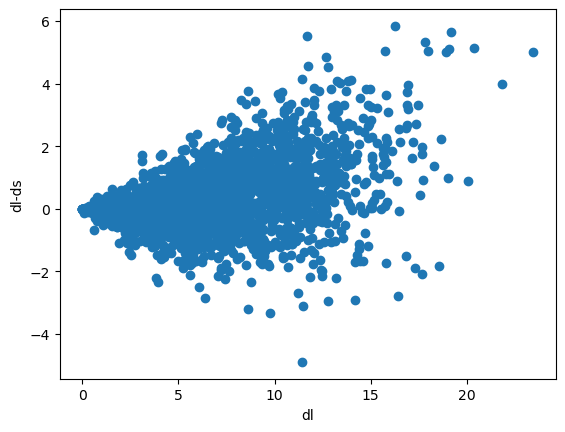

In [30]:
check_dl = []
for j in range(Mcz.shape[0]):
    check_dl.append(dl[j]-np.median(ds[j]))
    
plt.scatter(dl, check_dl)
plt.xlabel('dl')
plt.ylabel('dl-ds')

Text(0, 0.5, 'Theta-Thetas')

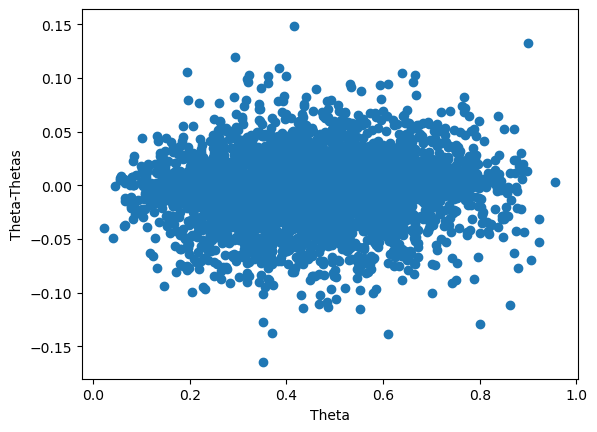

In [31]:
check_Theta = []
for j in range(Theta.shape[0]):
    check_Theta.append(Theta[j]-np.median(Thetas[j]))
    
plt.scatter(Theta, check_Theta)
plt.xlabel('Theta')
plt.ylabel('Theta-Thetas')

Text(0, 0.5, '$M_{cz}-M_{czs}$')

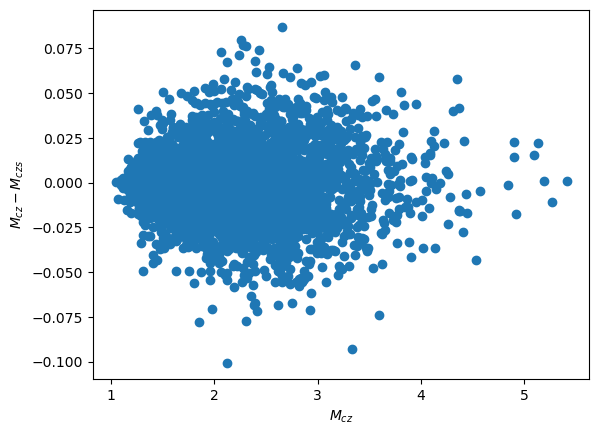

In [32]:
check_Mcz = []
for j in range(Mcz.shape[0]):
    check_Mcz.append(Mcz[j]-np.median(Mczs[j]))
    
plt.scatter(Mcz, check_Mcz)
plt.xlabel(r'$M_{cz}$')
plt.ylabel(r'$M_{cz}-M_{czs}$')

Text(0, 0.5, '$\\log q-\\log qs$')

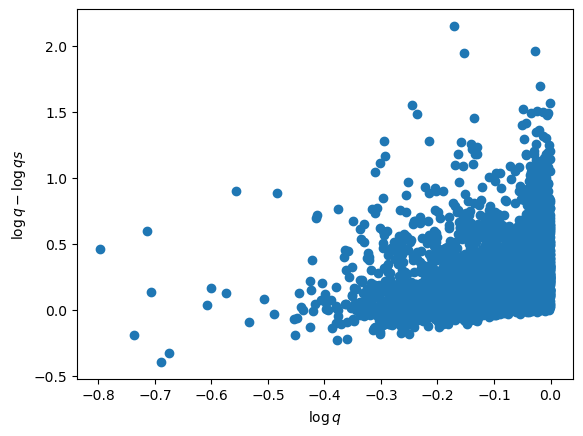

In [33]:
check_logq = []
for j in range(Mcz.shape[0]):
    check_logq.append(logq[j]-np.median(logqs[j]))
    
plt.scatter(logq, check_logq)
plt.xlabel(r'$\log q$')
plt.ylabel(r'$\log q-\log qs$')

In [34]:
max(Mczs.flatten()), max(logqs.flatten()), max(Thetas.flatten()), max(ds.flatten())

(5.48642627598775,
 -1.689657770365116e-07,
 0.9999455006297859,
 36.57866531133853)

In [35]:
min(Mczs.flatten()), min(logqs.flatten()), min(Thetas.flatten()), min(ds.flatten())

(1.042208754169844,
 -4.479643742214182,
 0.0006081050003749894,
 0.0010380922718203841)